In [ ]:
"""
QCB 551: Final Project - Figure 1C Reproduction
Author: Annita Chang (wc7800)
This notebook reproduces Fig 1C and 1E from the referenced dataset GSE211644.
"""

import pandas as pd
from scipy import io
import scanpy as sc

# Download Supplementary Files listed on https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE211644 before running this
base = "../GSE211644"

# read matrix and metadata
mat = io.mmread(f"{base}/GSE211644_fresh_matrix.mtx.gz").T.tocsr() # transpose and make sparse for efficient storage
genes = pd.read_csv(f"{base}/GSE211644_fresh_genes.tsv.gz", sep="\t", header=None)
barcodes = pd.read_csv(f"{base}/GSE211644_fresh_barcodes.tsv.gz", sep="\t", header=None)
meta = pd.read_csv(f"{base}/GSE211644_fresh_metadata.csv")
meta["cohort"] = meta["barcode"].str.split("_").str[0]
meta["sample_id"] = meta["barcode"].str.split("_").str[1]
meta["status"] = meta["barcode"].str.split("_").str[1].str.lower().map(lambda x: "tumor" if x.startswith("t") else ("unaffected" if x.startswith("u") else x))

# make AnnData object
adata = sc.AnnData(X=mat) # cell x gene matrix
adata.obs_names = barcodes.iloc[:, 0].astype(str).values # cells
adata.var_names = genes.iloc[:, 0].astype(str).values # genes
meta.index = meta["barcode"]
adata.obs = meta.reindex(adata.obs_names)
mda1 = adata[(adata.obs["status"] == "tumor") & (adata.obs["cohort"] == "MDA1")].copy()
mda2 = adata[(adata.obs["status"] == "tumor") & (adata.obs["cohort"] == "MDA2")].copy()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# code for legend, not used in final paper, just for presentation slides

# colorbar legend for average expression
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), gridspec_kw={"width_ratios":[1.2,1]})
dummy_expr = [0.25, 0.75, 1.25]
sc1 = ax1.scatter([0, 0, 0], range(len(dummy_expr)), s=150, c=dummy_expr, cmap='Greys', vmin=0, vmax=1.5)
sm = plt.cm.ScalarMappable(cmap='Greys', norm=plt.Normalize(vmin=0, vmax=1.5))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1, orientation='vertical', fraction=0.6, pad=0.12)
cbar.set_label('Average Expression', rotation=270, labelpad=20, fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax1.set_axis_off()

# dot size legend for percent expressed (right subplot)
dummy_fracs = [0.2, 0.4, 0.6, 0.8]
for frac in dummy_fracs:
    ax2.scatter([], [], s=frac*350, c='black', edgecolors='k', label=f'{int(frac*100)}%')
legend = ax2.legend(
    title='Percent Expressed',
    loc='center',
    bbox_to_anchor=(0.5, 0.51),
    scatterpoints=1,
    frameon=True,
    fontsize=16,
    title_fontsize=16,
    labelspacing=1.5,
    ncol=1
)
ax2.set_axis_off()
plt.tight_layout()
plt.show()




In [147]:
"""

Figure 1C: Dot plot of transcription factor expression in CD4+ and CD8+ TILs (combined, 4-panel figure)

"""

import matplotlib.pyplot as plt
import numpy as np

# read in TF gene lists
cd4_tfs = pd.read_csv("../1c_cd4_tf.txt", header=None)[0].str.strip().values.tolist()[::-1]
cd8_tfs = pd.read_csv("../1c_cd8_tf.txt", header=None)[0].str.strip().values.tolist()[::-1]

# get all clusters for CD4+ and CD8+
cd4_clusters = ['CD4 - FOXP3', 'CD4 - CXCR4', 'CD4 - CCR7', 'CD4 - CXCL13',  'CD4 - MX1']
cd8_clusters = ['CD8 - GZMK', 'CD8 - CCR7/IL7R', 'CD8 - ZNF683', 'CD8 - GZMB/PRF1', 'CD8 - CXCL13', 'CD8 - CXCR6/IL7R', 'CD8 - MX1']

def dotplot_data(adata, clusters, tf_list):
    """
    Calculate average expression and fraction expressed for each TF in tf_list
    over each of the specified clusters. Returns a tuple (tf_list, data, fractions).
    """
    cluster_cells = [adata.obs['cluster'] == clus for clus in clusters]
    data = []
    fractions = []
    for gene in tf_list:
        # get tf expression for all cells
        if gene in adata.var_names:
            gene_row = adata[:, gene].X.toarray()
        else:
            print(f"Gene {gene} not found")
            gene_row = np.full(adata.shape[0], np.nan)
        gene_expr_levels = []
        gene_fractions = []
        for mask in cluster_cells:
            expr = gene_row[mask]
            is_expr = expr > 0
            mean_expr = expr.mean() if np.any(is_expr) else 0
            frac_expr = is_expr.sum() / mask.sum()
            gene_expr_levels.append(mean_expr)
            gene_fractions.append(frac_expr)
        data.append(gene_expr_levels)
        fractions.append(gene_fractions)
    data = np.array(data)
    fractions = np.array(fractions)
    return tf_list, data, fractions

# calculate plots data for the 4 combinations (MDA1 CD8, MDA1 CD4, MDA2 CD8, MDA2 CD4)
tf8_mda1, d8_mda1, f8_mda1 = dotplot_data(mda1, cd8_clusters, cd8_tfs)
tf4_mda1, d4_mda1, f4_mda1 = dotplot_data(mda1, cd4_clusters, cd4_tfs)
tf8_mda2, d8_mda2, f8_mda2 = dotplot_data(mda2, cd8_clusters, cd8_tfs)
tf4_mda2, d4_mda2, f4_mda2 = dotplot_data(mda2, cd4_clusters, cd4_tfs)

Gene BATE not found
Gene BATE not found


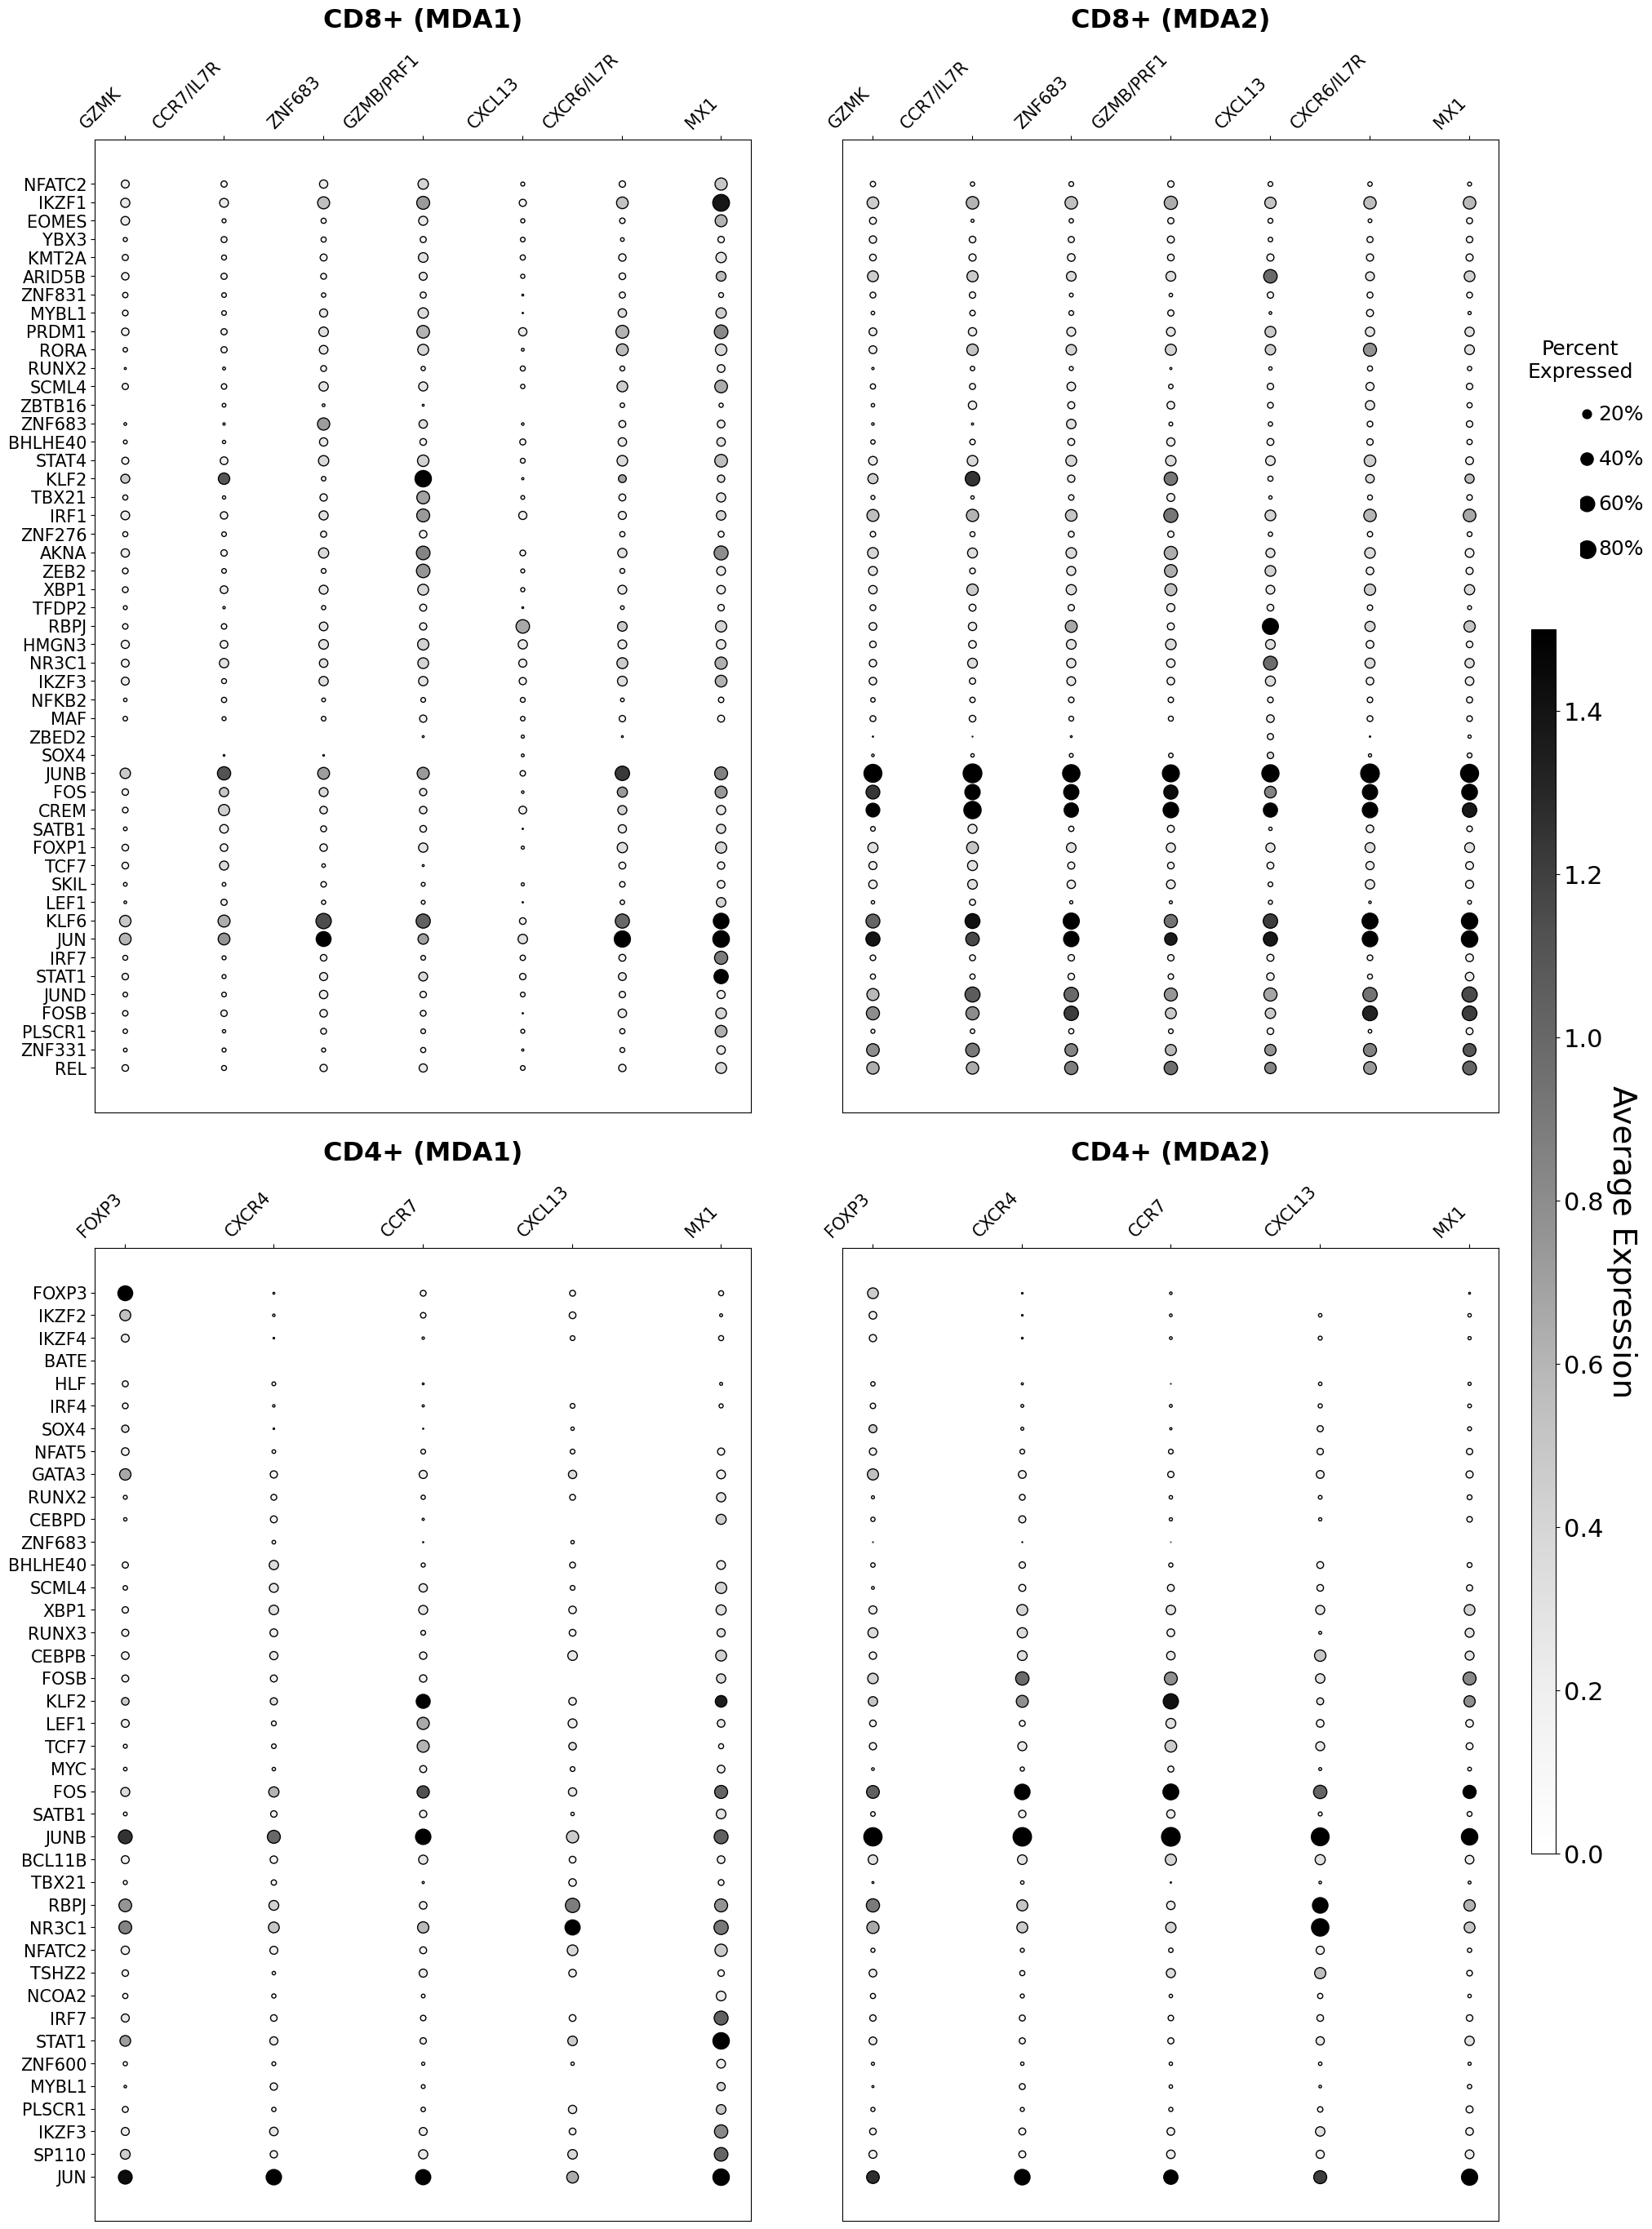

In [148]:
# code for plotting 1c
fig, axes = plt.subplots(2, 2, figsize=(20, 30), sharex=False, sharey=False,
                        gridspec_kw={'width_ratios':[1,1], 'height_ratios':[1,1]}) 

# set up panels
dot_panels = [
    (axes[0, 0], d8_mda1, f8_mda1, cd8_clusters, cd8_tfs, "MDA1", "CD8"),
    (axes[1, 0], d4_mda1, f4_mda1, cd4_clusters, cd4_tfs, "MDA1", "CD4"),
    (axes[0, 1], d8_mda2, f8_mda2, cd8_clusters, cd8_tfs, "MDA2", "CD8"),
    (axes[1, 1], d4_mda2, f4_mda2, cd4_clusters, cd4_tfs, "MDA2", "CD4"),
]

for ax, data, fractions, clusters, tf_list, cohort, CD4orCD8 in dot_panels:
    for i in range(len(tf_list)):
        for j in range(len(clusters)):
            ax.scatter(j, i, s=fractions[i, j]*300, c=np.array([[data[i, j]]]),
                       cmap="Greys", vmin=0, vmax=1.5, edgecolors='k')
            
    # format ticks and labels...
    ax.set_xticks(np.arange(len(clusters)))
    ax.set_xticklabels([c.split(" - ")[1] for c in clusters], rotation=45, ha='right', fontsize=15)
    ax.set_yticks(np.arange(len(tf_list)))
    ax.set_yticklabels(tf_list, fontsize=15)
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_title(f"{CD4orCD8}+ ({cohort})", fontsize=23, pad=20, fontweight='bold')

# ignore y-labels on right panels
axes[0, 1].set_yticks([])
axes[1, 1].set_yticks([])

# add shared colorbar and dot size legend

# dot size legend
size_ax = fig.add_axes([0.96, 0.75, 0.015, 0.08])
dummy_fracs = [0.2, 0.4, 0.6, 0.8]
for i, frac in enumerate(dummy_fracs):
    size_ax.scatter(0.5, 0.85-i*0.23, s=frac*size_scale, c='black', edgecolors='k')
    size_ax.text(1.5, 0.85-i*0.23, f'{int(frac*100)}%', va='center', ha='left', fontsize=18)
size_ax.axis('off')
size_ax.set_xlim(0, 2)
size_ax.set_ylim(0, 1)
size_ax.set_title('Percent\nExpressed', fontsize=18, ha='center', loc='left', pad=6)

# color bar
cax = fig.add_axes([0.93, 0.23, 0.015, 0.5], facecolor='none')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('Average Expression', rotation=270, labelpad=30, fontsize=28)
cbar.ax.tick_params(labelsize=22)

plt.subplots_adjust(left=0.05, right=0.91, wspace=0.14, hspace=0.14, top=0.93, bottom=0.08)
# fig.suptitle("Transcription Factor Expression in CD4+ and CD8+ TILs", fontsize=30, y=0.99)
plt.show()
plt.close(fig)

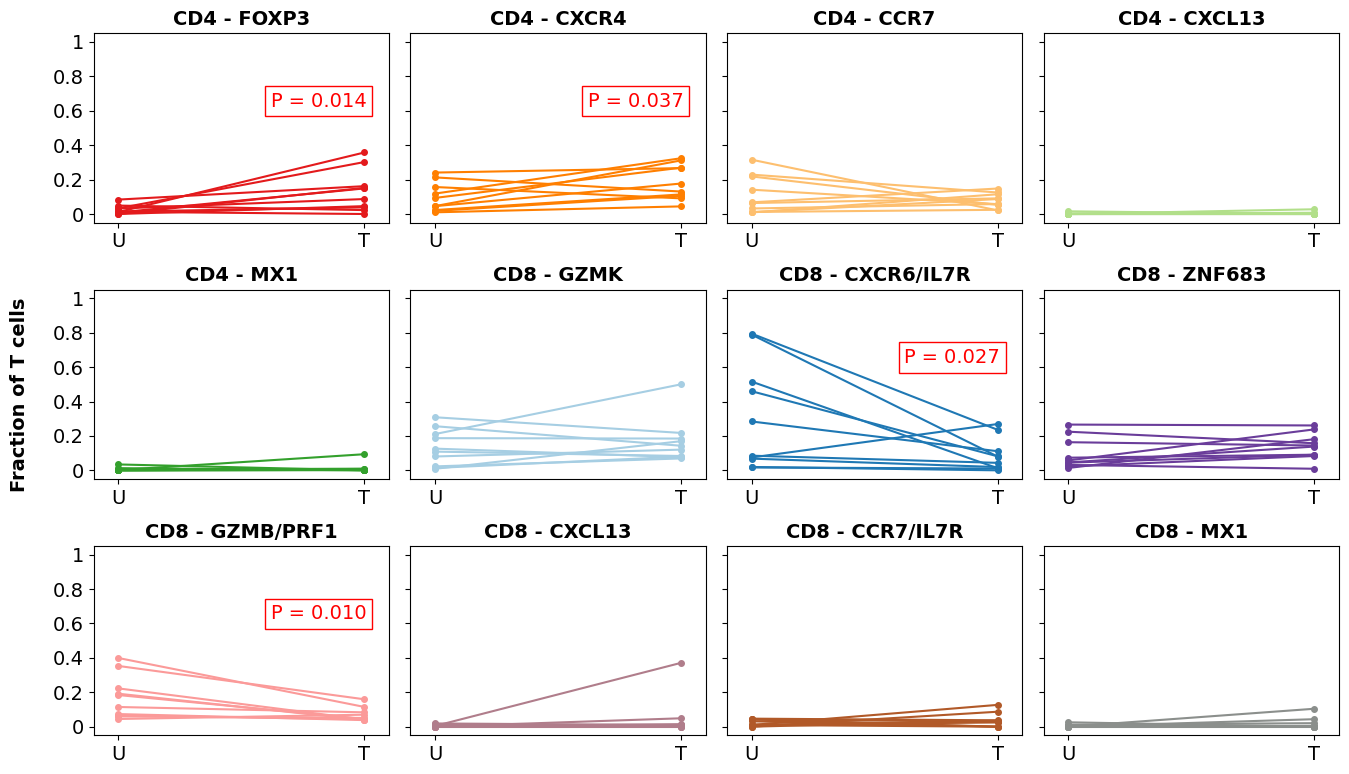

In [146]:
"""

Figure 1E : Comparison of T-cell state frequencies between matched tumor and uninvolved samples.

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# data preprocessing, only uses metadata
meta = pd.read_csv(f"{base}/GSE211644_fresh_metadata.csv")
meta["cohort_id"] = meta["barcode"].apply(lambda x: "_".join(x.split("_")[:2]))
meta["status"] = meta["barcode"].str.split("_").str[1].str.lower().map(lambda x: "tumor" if x.startswith("t") else ("unaffected" if x.startswith("u") else x))

# For each sample_id, calculate the fraction of cell states
cellstate_by_sample = meta.groupby("cohort_id")["cluster"].value_counts(normalize=True).unstack(fill_value=0)
cellstate_by_sample.columns.name = None
cellstate_by_sample.index.name = None

# row sum should be 1, sanity check
for sample_id, s in cellstate_by_sample.sum(axis=1).items():
    assert abs(s-1.0) < 1e-6

# unaffected-tumor sample pairs
sample_pairs = [
    ('MDA1_U05', 'MDA1_T05'), 
    ('MDA2_U02', 'MDA2_T02'), 
    ('MDA2_U05', 'MDA2_T05'), 
    ('MDA2_U08', 'MDA2_T08'), 
    ('MDA2_U09', 'MDA2_T09'),
    ('MDA2_U11', 'MDA2_T11'),
    ('MDA2_U15', 'MDA2_T15'),
    ('MDA2_U17', 'MDA2_T17'),
    ('MDA2_U18', 'MDA2_T18A'),
    ('MDA2_U24', 'MDA2_T24')]

# cell states to plot
cell_state_cols = [
    "CD4 - FOXP3", "CD4 - CXCR4", "CD4 - CCR7", "CD4 - CXCL13",
    "CD4 - MX1",   "CD8 - GZMK", "CD8 - CXCR6/IL7R", "CD8 - ZNF683",
    "CD8 - GZMB/PRF1", "CD8 - CXCL13", "CD8 - CCR7/IL7R", "CD8 - MX1"]

# color coding for each cell state
colors = [
    "#e31a1c", "#ff7f00", "#fdbf6f", "#b2df8a",
    "#33a02c", "#a6cee3", "#1f78b4", "#6a3d9a",
    "#fb9a99", "#b07d8b", "#b15928", "#8b8f8c"]

import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(3, 4, figsize=(14, 8), sharey=True)
axes = axes.flatten()
for i, state in enumerate(cell_state_cols):
    ax = axes[i]
    color = colors[i]
    paired_U = []
    paired_T = []
    for (u_id, t_id) in sample_pairs:
        u_val = cellstate_by_sample.loc[u_id][state]
        t_val = cellstate_by_sample.loc[t_id][state]
        paired_U.append(u_val)
        paired_T.append(t_val)
        ax.plot(
            [0, 1], [u_val, t_val],
            marker="o",
            linewidth=1.5,
            markersize=4,
            color=color
        )

    ax.set_xticks([0, 1])
    ax.set_xticklabels(["U", "T"], fontsize=14)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1"], fontsize=14)
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.05, 1.05)
    ax.set_title(state, fontsize=14, fontweight="bold", pad=6)

    # paired Wilcoxon p
    p = wilcoxon(paired_U, paired_T, alternative="two-sided").pvalue
    if p < 0.05:
        ax.text(0.6, 0.6, f"P = {p:.3f}",
                ha="left", va="bottom", fontsize=14, transform=ax.get_yaxis_transform(), color="red", bbox=dict(facecolor='none', edgecolor='red'))

fig.text(0.04, 0.5, "Fraction of T cells",
         va="center", rotation="vertical", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0.06, 0.02, 1, 1])
plt.show()

